In [28]:
import os
import py4j
from pdicommon import config
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession, SQLContext


# import boto3
import pandas as pd
from datetime import datetime 
from datetime import timedelta
from pyspark import SparkContext, HiveContext
from pyspark.sql.functions import *
import numpy as np
from pyspark.sql.types import StringType,BooleanType,DateType, IntegerType, DoubleType
from pyspark.sql.window import Window

import time
import re
# import h2o
# from h2o.estimators.gbm import H2OGradientBoostingEstimator
# from h2o.estimators.glm import H2OGeneralizedLinearEstimator
# from h2o.estimators import H2ORandomForestEstimator
# from h2o.grid.grid_search import H2OGridSearch
# import tempfile
# from os import listdir
# # import matplotlib.pyplot as plt
# import sklearn.metrics as metrics

# import pyarrow.parquet as pq
# import s3fs

# import requests
# import tabulate
# import future


In [2]:
config.load('we-offshore')
conf = SparkConf().set("spark.hadoop.fs.s3a.endpoint",'https://s3api-core.uhc.com')\
            .set("spark.hadoop.fs.s3a.impl","org.apache.hadoop.fs.s3a.S3AFileSystem")\
            .set("spark.hadoop.fs.s3a.access.key",'pQffiGbavztAv6oHYubm')\
            .set("spark.hadoop.fs.s3a.secret.key", 'Mb8uUAIn58YWsalinBwDrkShBjNbv0zXiwa9jFR6')\
            .set("com.amazonaws.services.s3a.enableV4", "true")\
            .set("spark.hadoop.fs.s3a.path.style.access","true")\
            .set("spark.hadoop.s3a.connection.ssl.enabled","false")\
            .set("fs.s3a.connection.ssl.enabled","true")\
            .set("spark.driver.memory", "64g")\
            .set("spark.executor.memory", "8g")\
            .set("spark.executor.cores", "4")\
            .set("spark.executor.instances", "4")\
            .set("spark.kubernetes.executor.limit.cores", "4")\
            .set("spark.kubernetes.executor.request.cores", "2500m")\
            .set("spark.driver.maxResultSize","64g")\
            .set("spark.executor.memoryOverhead","4096")\
            .set("spark.sql.broadcastTimeout", "36000")\
            .set( "spark.sql.crossJoin.enabled" , "true" )
            

spark = SparkSession.builder.appName("generic_model_uhc_data_2")\
            .config(conf = conf)\
            .getOrCreate()

2022-05-13 03:40:10,810 WARN  [main] util.NativeCodeLoader (NativeCodeLoader.java:<clinit>(60)) - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
# data = spark.read.parquet("s3a://as-bucket/ADS_1/ads_with_risk.parquet")
# data.count()

In [4]:
train_df = spark.read.parquet("s3a://as-bucket/model_data/train_data.parquet/*.parquet", header=True)
print(train_df.count())


2022-05-12 15:09:02,084 WARN  [Thread-4] impl.MetricsConfig (MetricsConfig.java:loadFirst(136)) - Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


10938215


In [5]:
valid_df = spark.read.parquet("s3a://as-bucket/model_data/valid_data.parquet/*.parquet", header=True)
print(valid_df.count())

1481409


In [6]:
test_df = spark.read.parquet("s3a://as-bucket/model_data/test_data.parquet/*.parquet", header=True)
print(test_df.count())

2737089


In [7]:
numeric_features = [t[0] for t in train_df.dtypes if t[1] in ['int', 'double']]
train_df.select(numeric_features).describe().toPandas().to_csv('desc_2.csv')

2022-05-12 15:10:31,022 WARN  [Thread-4] util.package (Logging.scala:logWarning(69)) - Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [8]:
train_df.groupBy('Target').count().show()

+------+-------+
|Target|  count|
+------+-------+
|     1|4559908|
|     0|6378307|
+------+-------+



In [9]:
features = [
    # 'r_bill_fein',
    #         'hdr_pay_to_prov_npi_id',
    #         'li_proc_cd',
    #         'hdr_diag_prim_cd',
    #         'hdr_clm_tcn',
    #         'batch_id',
    #         'line_num',
'Target',
'claim_srvc_days',
'diff_batch_srvc_dt',
'mod_59_ohe',
'billed_amt_per_unit',
'upcoded',
'unbundled_0',
'unbundled_1',
'plc_11',
'plc_12',
'plc_21',
'plc_22',
'plc_23',
'plc_24',
'plc_49',
'plc_81',
# 'prov_spec_Certified_Acupuncturist',
'prov_spec_Chiropractor',
# 'prov_spec_Clinical_Lab_MD_Directed',
'prov_spec_Clinical_Psychology',
'prov_spec_Emergency_Medicine',
'prov_spec_Gastroenterology',
'prov_spec_Independent_Lab_Non-MD',
'prov_spec_Occupational_Therapist',
'prov_spec_Oncology',
'prov_spec_Pathology',
# 'prov_spec_Pathology_Anatomic_&_Clinical',
'prov_spec_Pediatrics',
'prov_spec_Special_Provider_Agreement',
'proc_mod_HPV_HIGH-RISK_TYPES__REFERENCE_OUTSIDE_LABORATORY',
'proc_mod_L_HRT_ARTERY/VENTRICLE_ANGIO__PROFESSIONAL_COMPONENT',
'proc_mod_MANUAL_THERAPY_1/>_REGIONS__DISTINCT_PROCEDURAL_SERVICE',
'proc_mod_MEASURE_BLOOD_OXYGEN_LEVEL__DISTINCT_PROCEDURAL_SERVICE',
'proc_mod_OFFICE_O/P_EST_SF_10-19_MIN__SIGNIFICANT_SEPARATELY_IDENTIFIABLE_EVAL_&_MGMT_SVC_SAME_PHYSCN_AND_DAY',
'proc_mod_PER_PM_REEVAL_EST_PAT_INFANT__SIGNIFICANT_SEPARATELY_IDENTIFIABLE_EVAL_&_MGMT_SVC_SAME_PHYSCN_AND_DAY',
'proc_mod_THER/PROPH/DIAG_INJ_IV_PUSH__DISTINCT_PROCEDURAL_SERVICE',
'proc_mod_UNKNOWN_PROCEDURE__NEW_EQUIPMENT',
'diag_risk',
'proc_risk',
'prov_risk']

In [10]:
len(features)

37

In [11]:
train_data =  train_df.select(features)
valid_data =  valid_df.select(features)
test_data  =  test_df.select(features)

In [12]:
# # from pyspark.sql.functions import udf
# y_udf = udf(lambda y: "No" if y==0 else "yes", StringType())

# df=df.withColumn("Target_val", y_udf('Target')).drop("Target")

In [13]:
train_data = train_data.withColumn('Target', col('Target').cast(StringType()))
valid_data = valid_data.withColumn('Target', col('Target').cast(StringType()))
test_data = test_data.withColumn('Target', col('Target').cast(StringType()))

#### Features vectorization

In [29]:

# import matplotlib.pyplot as plt
import numpy as np
# import seaborn as sns

from pyspark.mllib.stat import Statistics
from pyspark.ml.feature import VectorAssembler,StandardScaler, StringIndexer
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix

In [30]:
cols = ['claim_srvc_days', 'diff_batch_srvc_dt', 'mod_59_ohe', 'billed_amt_per_unit', 'upcoded', 'unbundled_0', 'unbundled_1', 'plc_11', 'plc_12', 'plc_21', 'plc_22', 'plc_23', 'plc_24',\
        'plc_49', 'plc_81', 'prov_spec_Chiropractor', 'prov_spec_Clinical_Psychology', 'prov_spec_Emergency_Medicine', 'prov_spec_Gastroenterology', 'prov_spec_Independent_Lab_Non-MD',\
        'prov_spec_Occupational_Therapist',  'prov_spec_Oncology', 'prov_spec_Pathology', 'prov_spec_Pediatrics', 'prov_spec_Special_Provider_Agreement', 'proc_mod_HPV_HIGH-RISK_TYPES__REFERENCE_OUTSIDE_LABORATORY',\
        'proc_mod_L_HRT_ARTERY/VENTRICLE_ANGIO__PROFESSIONAL_COMPONENT', 'proc_mod_MANUAL_THERAPY_1/>_REGIONS__DISTINCT_PROCEDURAL_SERVICE', 'proc_mod_MEASURE_BLOOD_OXYGEN_LEVEL__DISTINCT_PROCEDURAL_SERVICE',\
        'proc_mod_OFFICE_O/P_EST_SF_10-19_MIN__SIGNIFICANT_SEPARATELY_IDENTIFIABLE_EVAL_&_MGMT_SVC_SAME_PHYSCN_AND_DAY', 'proc_mod_PER_PM_REEVAL_EST_PAT_INFANT__SIGNIFICANT_SEPARATELY_IDENTIFIABLE_EVAL_&_MGMT_SVC_SAME_PHYSCN_AND_DAY',\
        'proc_mod_THER/PROPH/DIAG_INJ_IV_PUSH__DISTINCT_PROCEDURAL_SERVICE', 'proc_mod_UNKNOWN_PROCEDURE__NEW_EQUIPMENT', 'diag_risk', 'proc_risk', 'prov_risk']
stages = []
# for categoricalCol in categoricalColumns:
#     stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
#     encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
#     stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'Target', outputCol = 'label')
stages += [label_stringIdx]
numericCols = cols 
assemblerInputs = numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="vectorized_features")
stages += [assembler]
scaler = StandardScaler(inputCol="vectorized_features", outputCol="features")
stages += [scaler]

In [32]:
# train_data.columns

In [33]:
stages

[StringIndexer_ddf0b5576a18,
 VectorAssembler_12d6f517533a,
 StandardScaler_c95795abce63]

In [18]:
pd.set_option('display.max_colwidth', 300)
# pd.set_option('max_columns', 12)

In [19]:
cols = train_data.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(train_data)
train_data_2 = pipelineModel.transform(train_data)
selectedCols = ['label','vectorized_features','features'] + cols
train_data_2 = train_data_2.select(selectedCols)
train_data_2.printSchema()

root
 |-- label: double (nullable = false)
 |-- vectorized_features: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- Target: string (nullable = true)
 |-- claim_srvc_days: integer (nullable = true)
 |-- diff_batch_srvc_dt: integer (nullable = true)
 |-- mod_59_ohe: integer (nullable = true)
 |-- billed_amt_per_unit: double (nullable = true)
 |-- upcoded: integer (nullable = true)
 |-- unbundled_0: integer (nullable = true)
 |-- unbundled_1: integer (nullable = true)
 |-- plc_11: integer (nullable = true)
 |-- plc_12: integer (nullable = true)
 |-- plc_21: integer (nullable = true)
 |-- plc_22: integer (nullable = true)
 |-- plc_23: integer (nullable = true)
 |-- plc_24: integer (nullable = true)
 |-- plc_49: integer (nullable = true)
 |-- plc_81: integer (nullable = true)
 |-- prov_spec_Chiropractor: integer (nullable = true)
 |-- prov_spec_Clinical_Psychology: integer (nullable = true)
 |-- prov_spec_Emergency_Medicine: integer (nullable = true)
 |-- prov_spec_Ga

In [20]:

train_data_2.limit(3).toPandas().head()

,label,vectorized_features,features,Target,claim_srvc_days,diff_batch_srvc_dt,mod_59_ohe,billed_amt_per_unit,upcoded,unbundled_0,...,proc_mod_L_HRT_ARTERY/VENTRICLE_ANGIO__PROFESSIONAL_COMPONENT,proc_mod_MANUAL_THERAPY_1/>_REGIONS__DISTINCT_PROCEDURAL_SERVICE,proc_mod_MEASURE_BLOOD_OXYGEN_LEVEL__DISTINCT_PROCEDURAL_SERVICE,proc_mod_OFFICE_O/P_EST_SF_10-19_MIN__SIGNIFICANT_SEPARATELY_IDENTIFIABLE_EVAL_&_MGMT_SVC_SAME_PHYSCN_AND_DAY,proc_mod_PER_PM_REEVAL_EST_PAT_INFANT__SIGNIFICANT_SEPARATELY_IDENTIFIABLE_EVAL_&_MGMT_SVC_SAME_PHYSCN_AND_DAY,proc_mod_THER/PROPH/DIAG_INJ_IV_PUSH__DISTINCT_PROCEDURAL_SERVICE,proc_mod_UNKNOWN_PROCEDURE__NEW_EQUIPMENT,diag_risk,proc_risk,prov_risk
0,0.0,"(0.0, 104.0, 0.0, 1.6717324222015977, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6791658768112461, 0.7743547306861278, 0.6929701226881594)","(0.0, 2.0885698479182584, 0.0, 0.2115094941480325, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.904732040594621, 3.542901614426638, 3.2254168746167435)",0,0,104,0,1.671732,0,0,...,0,0,0,0,0,0,0,0.679166,0.774355,0.692970
1,1.0,"(127.0, 6.0, 0.0, 1.0585918074098126, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7866139211317161, 0.6641439571481443, 0.9635966116218978)","(0.009958754488939044, 0.12049441430297644, 0.0, 0.13393424373479074, 0.0, 0.0, 0.0, 2.008928456684171, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.813755476321053, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.83889544847537, 3.038654772479986, 4.485042961725789)",1,127,6,0,1.058592,0,0,...,0,0,0,0,0,0,0,0.786614,0.664144,0.963597
2,1.0,"(2.0, 181.0, 0.0, 1.7226016141015086, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.687094443309875, 0.8635445935553455, 0.6034660374408587)","(0.00015683077935337077, 3.634914831473123, 0.0, 0.2179455223685654, 0.0, 0.0, 0.0, 2.008928456684171, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.973663743789496, 3.9509715811069652, 2.8088217322693287)",1,2,181,0,1.722602,0,0,...,0,0,0,0,0,0,0,0.687094,0.863545,0.603466


In [21]:
len(train_data_2.columns)

40

In [22]:
cols = valid_data.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(valid_data)
valid_data_2 = pipelineModel.transform(valid_data)
selectedCols = ['label', 'vectorized_features','features'] + cols
valid_data_2 = valid_data_2.select(selectedCols)
valid_data_2.printSchema()

root
 |-- label: double (nullable = false)
 |-- vectorized_features: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- Target: string (nullable = true)
 |-- claim_srvc_days: integer (nullable = true)
 |-- diff_batch_srvc_dt: integer (nullable = true)
 |-- mod_59_ohe: integer (nullable = true)
 |-- billed_amt_per_unit: double (nullable = true)
 |-- upcoded: integer (nullable = true)
 |-- unbundled_0: integer (nullable = true)
 |-- unbundled_1: integer (nullable = true)
 |-- plc_11: integer (nullable = true)
 |-- plc_12: integer (nullable = true)
 |-- plc_21: integer (nullable = true)
 |-- plc_22: integer (nullable = true)
 |-- plc_23: integer (nullable = true)
 |-- plc_24: integer (nullable = true)
 |-- plc_49: integer (nullable = true)
 |-- plc_81: integer (nullable = true)
 |-- prov_spec_Chiropractor: integer (nullable = true)
 |-- prov_spec_Clinical_Psychology: integer (nullable = true)
 |-- prov_spec_Emergency_Medicine: integer (nullable = true)
 |-- prov_spec_Ga

In [23]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=5)
lrModel = lr.fit(train_data_2)
predictions = lrModel.transform(valid_data_2)
#predictions_train = lrModel.transform(train)


In [24]:
predictions.select('label', 'features',  'rawPrediction', 'prediction', 'probability').limit(20).toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,1.0,"(0.010839484031602209, 0.41865120606704553, 0.0, 0.4171154573132441, 2.720664103432804, 0.0, 0.0, 2.0000000267350644, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.3993476572927905, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.37640208723222, 3.04322716047391, 3....","[-1.2214074054404116, 1.2214074054404116]",1.0,"[0.227688868199236, 0.772311131800764]"
1,0.0,"(0.0, 2.131315230886777, 0.0, 0.15780767520195826, 0.0, 0.0, 0.0, 2.0000000267350644, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.590486664739189, 0.36266499757298887, 2.117963611122892)","[1.5387563127991404, -1.5387563127991404]",0.0,"[0.8232838569636941, 0.1767161430363059]"
2,0.0,"(0.0, 0.38059200551549593, 0.0, 0.23706746723943614, 0.0, 0.0, 0.0, 2.0000000267350644, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.590486664739189, 2.3775113576430638, 1.9735249074253416)","[-0.0367209613587689, 0.0367209613587689]",1.0,"[0.4908207910964203, 0.5091792089035797]"
3,1.0,"(0.0012698977108153216, 0.3615624052397211, 0.0, 0.11590902557972856, 0.0, 0.0, 0.0, 2.0000000267350644, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.108974114147155, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.9422473063505, 3.4165849547830627, 3.2672267875075...","[-1.1633854358436202, 1.1633854358436202]",1.0,"[0.23805267816416237, 0.7619473218358377]"
4,1.0,"(0.0, 0.19029600275774797, 0.0, 0.8755518485347796, 0.0, 0.0, 0.0, 2.0000000267350644, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.725366353609711, 1.20476193334613, 2.2782873716721372)","[0.6305419921793667, -0.6305419921793667]",0.0,"[0.6526123471146713, 0.3473876528853287]"


In [25]:
# !pip install matplotlib

In [35]:
import matplotlib.pyplot as plt


In [36]:
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[425550 243213]
 [201726 610920]]


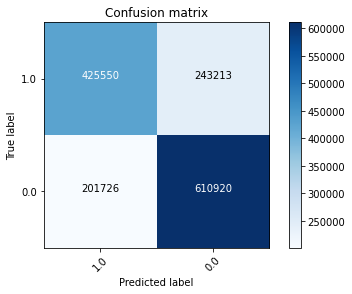

In [28]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [29]:
accuracy=(cnf_matrix[0][0]+cnf_matrix[1][1])/cnf_matrix.sum()
precision=(cnf_matrix[0][0])/(cnf_matrix[0][0]+cnf_matrix[1][0])
recall=(cnf_matrix[0][0])/(cnf_matrix[0][0]+cnf_matrix[0][1])
print("LR Model accuracy: ",accuracy)
print("LR Model precision: ",precision)
print("LR Model recall: ",recall)
print("LR Model F1-Score: ",(precision*recall)/(precision + recall))

LR Model accuracy:  0.699651480448681
LR Model precision:  0.6784095039504142
LR Model recall:  0.6363240789337927
LR Model F1-Score:  0.328346600680998


In [30]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.699651480448681


/opt/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


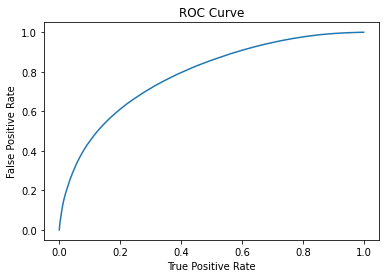

Training set areaUnderROC: 0.7840827905648798


In [31]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [32]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.7596451972165835


### LR Model - OOT

In [33]:
## OOT:
cols = test_data.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(test_data)
test_data_2 = pipelineModel.transform(test_data)
selectedCols = ['label', 'vectorized_features','features'] + cols
test_data_2 = test_data_2.select(selectedCols)
test_data_2.printSchema()

root
 |-- label: double (nullable = false)
 |-- vectorized_features: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- Target: string (nullable = true)
 |-- claim_srvc_days: integer (nullable = true)
 |-- diff_batch_srvc_dt: integer (nullable = true)
 |-- mod_59_ohe: integer (nullable = true)
 |-- billed_amt_per_unit: double (nullable = true)
 |-- upcoded: integer (nullable = true)
 |-- unbundled_0: integer (nullable = true)
 |-- unbundled_1: integer (nullable = true)
 |-- plc_11: integer (nullable = true)
 |-- plc_12: integer (nullable = true)
 |-- plc_21: integer (nullable = true)
 |-- plc_22: integer (nullable = true)
 |-- plc_23: integer (nullable = true)
 |-- plc_24: integer (nullable = true)
 |-- plc_49: integer (nullable = true)
 |-- plc_81: integer (nullable = true)
 |-- prov_spec_Chiropractor: integer (nullable = true)
 |-- prov_spec_Clinical_Psychology: integer (nullable = true)
 |-- prov_spec_Emergency_Medicine: integer (nullable = true)
 |-- prov_spec_Ga

In [34]:
predictions_test = lrModel.transform(test_data_2)

Confusion matrix, without normalization
[[ 768639  432919]
 [ 438800 1096731]]


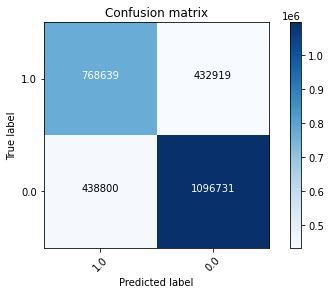

In [35]:
y_true = predictions_test.select("label")
y_true = y_true.toPandas()

y_pred = predictions_test.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [36]:
accuracy = predictions_test.filter(predictions_test.label == predictions_test.prediction).count() / float(predictions_test.count())
print("Accuracy : ",accuracy)

Accuracy :  0.6815160193914045


In [37]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions_test))

Test Area Under ROC 0.737388438029374


In [38]:
accuracy=(cnf_matrix[0][0]+cnf_matrix[1][1])/cnf_matrix.sum()
precision=(cnf_matrix[0][0])/(cnf_matrix[0][0]+cnf_matrix[1][0])
recall=(cnf_matrix[0][0])/(cnf_matrix[0][0]+cnf_matrix[0][1])
print("LR Model accuracy: ",accuracy)
print("LR Model precision: ",precision)
print("LR Model recall: ",recall)
print("LR Model F1-Score: ",(precision*recall)/(precision + recall))

LR Model accuracy:  0.6815160193914045
LR Model precision:  0.6365861960728451
LR Model recall:  0.6397019536302034
LR Model F1-Score:  0.31907013582831356


In [39]:
# lrModel.save('temp')

## Grid Search

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.1, 0.2, 0.35, 0.6, 0.8])# regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])# Elastic Net Parameter (Ridge = 0)
             .addGrid(lr.maxIter, [1, 5, 10])#Number of iterations
             .build())

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, 
                    evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train_data_2)

In [61]:
## Evaluate Best Model
predictions_2 = cvModel.transform(valid_data_2)
print('Best Model Test Area Under ROC', evaluator.evaluate(predictions_2))

Best Model Test Area Under ROC 0.7598141764793838


In [62]:
cvModel.bestModel

LogisticRegressionModel: uid=LogisticRegression_60b4e55a2cd5, numClasses=2, numFeatures=36

In [63]:
best_model=cvModel.bestModel

In [64]:
print('Best Model Regularization param: ',best_model._java_obj.getRegParam())
print('Best Model max number of iterations  param: ',best_model._java_obj.getMaxIter())
print('Best Model ElasticNet mixing parameter param: ',best_model._java_obj.getElasticNetParam())

Best Model Regularization param:  0.01
Best Model max number of iterations  param:  10
Best Model ElasticNet mixing parameter param:  0.0


## Evaluation:

### Train

/opt/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


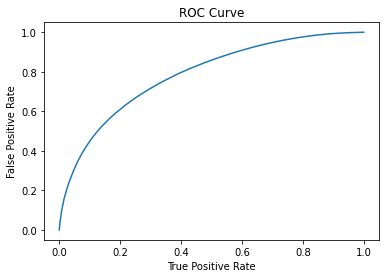

Training set areaUnderROC: 0.7840820497421873


In [65]:
# ROC

trainingSummary = best_model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

/opt/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


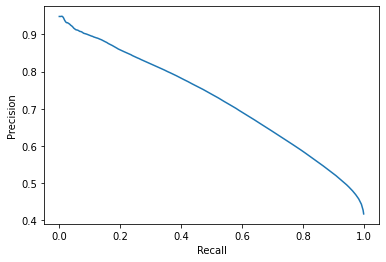

In [66]:
## Precision and recall.

pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

## Valid

In [67]:
## Evaluate our Logistic Regression model.

from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions_2))

Test Area Under ROC 0.7598159793606256


Confusion matrix, without normalization
[[425868 242895]
 [201698 610948]]


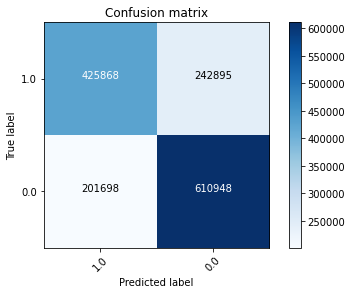

In [68]:
y_true = predictions_2.select("label")
y_true = y_true.toPandas()

y_pred = predictions_2.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [69]:
accuracy=(cnf_matrix[0][0]+cnf_matrix[1][1])/cnf_matrix.sum()
precision=(cnf_matrix[0][0])/(cnf_matrix[0][0]+cnf_matrix[1][0])
recall=(cnf_matrix[0][0])/(cnf_matrix[0][0]+cnf_matrix[0][1])
print("LR Model accuracy: ",accuracy)
print("LR Model precision: ",precision)
print("LR Model recall: ",recall)
print("LR Model F1-Score: ",(precision*recall)/(precision + recall))

LR Model accuracy:  0.6998850418756738
LR Model precision:  0.6786027286373066
LR Model recall:  0.636799583709027
LR Model F1-Score:  0.3285184548058402


In [70]:
accuracy = predictions_2.filter(predictions_2.label == predictions_2.prediction).count() / float(predictions_2.count())
print("Accuracy : ",accuracy)

Accuracy :  0.6998850418756738


### OOT - 

In [71]:
## Evaluate Best Model
predictions_test_2 = cvModel.transform(test_data_2)
print('Best Model Test Area Under ROC', evaluator.evaluate(predictions_test_2))

Best Model Test Area Under ROC 0.7378083703033235


In [72]:
## Evaluate our Logistic Regression model.

from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions_test_2))

Test Area Under ROC 0.7378076441485611


Confusion matrix, without normalization
[[ 767275  434283]
 [ 436904 1098627]]


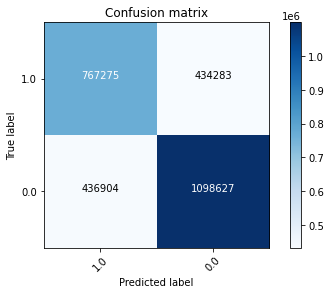

In [73]:
y_true = predictions_test_2.select("label")
y_true = y_true.toPandas()

y_pred = predictions_test_2.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [74]:
accuracy=(cnf_matrix[0][0]+cnf_matrix[1][1])/cnf_matrix.sum()
precision=(cnf_matrix[0][0])/(cnf_matrix[0][0]+cnf_matrix[1][0])
recall=(cnf_matrix[0][0])/(cnf_matrix[0][0]+cnf_matrix[0][1])
print("LR Model accuracy: ",accuracy)
print("LR Model precision: ",precision)
print("LR Model recall: ",recall)
print("LR Model F1-Score: ",(precision*recall)/(precision + recall))

LR Model accuracy:  0.6817103864726357
LR Model precision:  0.6371768649013145
LR Model recall:  0.6385667608221992
LR Model F1-Score:  0.3189355278652654


In [76]:
accuracy = predictions_test_2.filter(predictions_test_2.label == predictions_test_2.prediction).count() / float(predictions_test_2.count())
print("Accuracy : ",accuracy)

Accuracy :  0.6817103864726357


In [77]:
predictions_test_2.count()

2737089

In [78]:
type(predictions_test_2)

pyspark.sql.dataframe.DataFrame

In [79]:
type(best_model)

pyspark.ml.classification.LogisticRegressionModel

In [75]:
## Evaluate Best Model
temp = best_model.transform(valid_data_2)
print('Best Model Test Area Under ROC', evaluator.evaluate(temp))

Best Model Test Area Under ROC 0.7598142724713106


In [85]:
# best_model.save()

In [84]:
# best_model.write().overwrite().save("file:/home/asaxen83/model/lr_best_model_2/metadata/_temporary/0/_temporary/model_obj")

model_path ="s3a://as-bucket/model_obj/pyspark_model/lr_model_1.model"

best_model.save(model_path)

## Load LR Model

In [41]:
from pyspark.ml.classification import LogisticRegressionModel
model_path ="s3a://as-bucket/model_obj/pyspark_model/lr_model_1.model"
model = LogisticRegressionModel.load(model_path)

In [42]:
model.featuresCol

Param(parent='LogisticRegression_60b4e55a2cd5', name='featuresCol', doc='features column name.')

In [43]:
weights = model.coefficients
# weights = [(float(w),) for w in weights]
# weightsDF = sqlContext.createDataFrame(weights, ["Feature Weight"])
# weightsDF.toPandas().head(10)

In [44]:
weights

DenseVector([-0.0002, -0.0495, -0.0019, 0.0386, 0.0463, 0.023, 0.0304, -0.0098, 0.0167, 0.029, 0.0242, -0.042, -0.0048, 0.0008, 0.0024, -0.0669, 0.0315, -0.0201, 0.0225, 0.0115, -0.0727, -0.005, -0.0145, 0.0004, -0.0419, 0.0022, -0.0103, 0.0101, 0.0008, 0.0072, -0.0317, -0.0047, 0.0046, 0.059, 0.7263, 0.653])

## HPHC Score

In [21]:
hphc_df = spark.read.parquet("s3a://as-bucket/client_data/hphc/ads_w_risk/data.parquet/*.parquet")
hphc_df.count()

67467

In [22]:
hphc_df.limit(5).toPandas()

,r_bill_fein,hdr_pay_to_prov_npi_id,li_proc_cd,hdr_diag_prim_cd,hdr_clm_tcn,batch_id,line_num,claim_srvc_days,diff_batch_srvc_dt,mod_59_ohe,...,proc_mod_MANUAL_THERAPY_1/>_REGIONS__DISTINCT_PROCEDURAL_SERVICE,proc_mod_MEASURE_BLOOD_OXYGEN_LEVEL__DISTINCT_PROCEDURAL_SERVICE,proc_mod_OFFICE_O/P_EST_SF_10-19_MIN__SIGNIFICANT_SEPARATELY_IDENTIFIABLE_EVAL_&_MGMT_SVC_SAME_PHYSCN_AND_DAY,proc_mod_PER_PM_REEVAL_EST_PAT_INFANT__SIGNIFICANT_SEPARATELY_IDENTIFIABLE_EVAL_&_MGMT_SVC_SAME_PHYSCN_AND_DAY,proc_mod_THER/PROPH/DIAG_INJ_IV_PUSH__DISTINCT_PROCEDURAL_SERVICE,proc_mod_UNKNOWN_PROCEDURE__NEW_EQUIPMENT,Target,diag_risk,proc_risk,prov_risk
0,455391610,None,99204,J029,200330070256,20211020010,10.0,0,592,0,...,0,0,0,0,0,0,1,0.507206,0.520127,0.367248
1,043205435,None,73562,M1712,200828620105,20211021010,30.0,0,709,0,...,0,0,0,0,0,0,0,0.405691,0.334972,0.364145
2,060646652,None,93356,U071,201106M66345,20210610010,20.0,0,220,0,...,0,0,0,0,0,0,0,0.590578,0.248204,0.367248
3,020315693,None,None,I214,201130M67995,20210621010,170.0,2,214,0,...,0,0,0,0,0,0,0,0.249504,0.416649,0.217488
4,020232673,None,93325,R079,210127M63372,20210610010,20.0,0,139,0,...,0,0,0,0,0,0,0,0.436952,0.254256,0.638110


In [23]:
# flbl_df.printSchema()

In [24]:
features = [
'Target',
'claim_srvc_days',
'diff_batch_srvc_dt',
'mod_59_ohe',
'billed_amt_per_unit',
'upcoded',
'unbundled_0',
'unbundled_1',
'plc_11',
'plc_12',
'plc_21',
'plc_22',
'plc_23',
'plc_24',
'plc_49',
'plc_81',
'prov_spec_Chiropractor',
'prov_spec_Clinical_Psychology',
'prov_spec_Emergency_Medicine',
'prov_spec_Gastroenterology',
'prov_spec_Independent_Lab_Non-MD',
'prov_spec_Occupational_Therapist',
'prov_spec_Oncology',
'prov_spec_Pathology',
'prov_spec_Pediatrics',
'prov_spec_Special_Provider_Agreement',
'proc_mod_HPV_HIGH-RISK_TYPES__REFERENCE_OUTSIDE_LABORATORY',
'proc_mod_L_HRT_ARTERY/VENTRICLE_ANGIO__PROFESSIONAL_COMPONENT',
'proc_mod_MANUAL_THERAPY_1/>_REGIONS__DISTINCT_PROCEDURAL_SERVICE',
'proc_mod_MEASURE_BLOOD_OXYGEN_LEVEL__DISTINCT_PROCEDURAL_SERVICE',
'proc_mod_OFFICE_O/P_EST_SF_10-19_MIN__SIGNIFICANT_SEPARATELY_IDENTIFIABLE_EVAL_&_MGMT_SVC_SAME_PHYSCN_AND_DAY',
'proc_mod_PER_PM_REEVAL_EST_PAT_INFANT__SIGNIFICANT_SEPARATELY_IDENTIFIABLE_EVAL_&_MGMT_SVC_SAME_PHYSCN_AND_DAY',
'proc_mod_THER/PROPH/DIAG_INJ_IV_PUSH__DISTINCT_PROCEDURAL_SERVICE',
'proc_mod_UNKNOWN_PROCEDURE__NEW_EQUIPMENT',
'diag_risk',
'proc_risk',
'prov_risk']

In [37]:
hphc_data = hphc_df.select(features)

In [38]:
hphc_data.printSchema()

root
 |-- Target: string (nullable = true)
 |-- claim_srvc_days: integer (nullable = true)
 |-- diff_batch_srvc_dt: integer (nullable = true)
 |-- mod_59_ohe: integer (nullable = true)
 |-- billed_amt_per_unit: double (nullable = true)
 |-- upcoded: integer (nullable = true)
 |-- unbundled_0: integer (nullable = true)
 |-- unbundled_1: integer (nullable = true)
 |-- plc_11: integer (nullable = true)
 |-- plc_12: integer (nullable = true)
 |-- plc_21: integer (nullable = true)
 |-- plc_22: integer (nullable = true)
 |-- plc_23: integer (nullable = true)
 |-- plc_24: integer (nullable = true)
 |-- plc_49: integer (nullable = true)
 |-- plc_81: integer (nullable = true)
 |-- prov_spec_Chiropractor: integer (nullable = true)
 |-- prov_spec_Clinical_Psychology: integer (nullable = true)
 |-- prov_spec_Emergency_Medicine: integer (nullable = true)
 |-- prov_spec_Gastroenterology: integer (nullable = true)
 |-- prov_spec_Independent_Lab_Non-MD: integer (nullable = true)
 |-- prov_spec_Occupat

In [39]:
# train_data = train_data.withColumn('Target', col('Target').cast(StringType()))

hphc_data.groupBy('Target').count().show()

+------+-----+
|Target|count|
+------+-----+
|     0|52024|
|     1|15443|
+------+-----+



In [40]:
cols = hphc_data.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(hphc_data)
hphc_data_2 = pipelineModel.transform(hphc_data)
selectedCols = ['label', 'vectorized_features','features'] + cols
hphc_data_2 = hphc_data_2.select(selectedCols)
hphc_data_2.printSchema()

root
 |-- label: double (nullable = false)
 |-- vectorized_features: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- Target: string (nullable = true)
 |-- claim_srvc_days: integer (nullable = true)
 |-- diff_batch_srvc_dt: integer (nullable = true)
 |-- mod_59_ohe: integer (nullable = true)
 |-- billed_amt_per_unit: double (nullable = true)
 |-- upcoded: integer (nullable = true)
 |-- unbundled_0: integer (nullable = true)
 |-- unbundled_1: integer (nullable = true)
 |-- plc_11: integer (nullable = true)
 |-- plc_12: integer (nullable = true)
 |-- plc_21: integer (nullable = true)
 |-- plc_22: integer (nullable = true)
 |-- plc_23: integer (nullable = true)
 |-- plc_24: integer (nullable = true)
 |-- plc_49: integer (nullable = true)
 |-- plc_81: integer (nullable = true)
 |-- prov_spec_Chiropractor: integer (nullable = true)
 |-- prov_spec_Clinical_Psychology: integer (nullable = true)
 |-- prov_spec_Emergency_Medicine: integer (nullable = true)
 |-- prov_spec_Ga

In [45]:
predictions_hphc = model.transform(hphc_data_2)

Confusion matrix, without normalization
[[11496  3947]
 [29060 22964]]


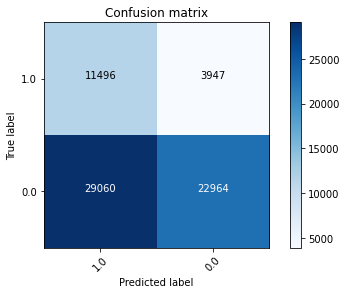

In [46]:
y_true = predictions_hphc.select("label")
y_true = y_true.toPandas()

y_pred = predictions_hphc.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [47]:
accuracy=(cnf_matrix[0][0]+cnf_matrix[1][1])/cnf_matrix.sum()
precision=(cnf_matrix[0][0])/(cnf_matrix[0][0]+cnf_matrix[1][0])
recall=(cnf_matrix[0][0])/(cnf_matrix[0][0]+cnf_matrix[0][1])
print("LR Model accuracy: ",accuracy)
print("LR Model precision: ",precision)
print("LR Model recall: ",recall)
print("LR Model F1-Score: ",(precision*recall)/(precision + recall))

LR Model accuracy:  0.5107682274297064
LR Model precision:  0.28345990728868725
LR Model recall:  0.7444149452826523
LR Model F1-Score:  0.205289380167503


In [48]:
accuracy = predictions_hphc.filter(predictions_hphc.label == predictions_hphc.prediction).count() / float(predictions_hphc.count())
print("Accuracy : ",accuracy)

Accuracy :  0.5107682274297064


In [49]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions_hphc))

Test Area Under ROC 0.6304874995107085


## BSCA Score

In [50]:
bsca_df = spark.read.parquet("s3a://as-bucket/client_data/bsca/ads_w_risk/data.parquet/*.parquet")
bsca_df.count()

452655

In [51]:
bsca_df.limit(5).toPandas()

,r_bill_fein,hdr_pay_to_prov_npi_id,li_proc_cd,hdr_diag_prim_cd,hdr_clm_tcn,batch_id,line_num,claim_srvc_days,diff_batch_srvc_dt,mod_59_ohe,...,proc_mod_MANUAL_THERAPY_1/>_REGIONS__DISTINCT_PROCEDURAL_SERVICE,proc_mod_MEASURE_BLOOD_OXYGEN_LEVEL__DISTINCT_PROCEDURAL_SERVICE,proc_mod_OFFICE_O/P_EST_SF_10-19_MIN__SIGNIFICANT_SEPARATELY_IDENTIFIABLE_EVAL_&_MGMT_SVC_SAME_PHYSCN_AND_DAY,proc_mod_PER_PM_REEVAL_EST_PAT_INFANT__SIGNIFICANT_SEPARATELY_IDENTIFIABLE_EVAL_&_MGMT_SVC_SAME_PHYSCN_AND_DAY,proc_mod_THER/PROPH/DIAG_INJ_IV_PUSH__DISTINCT_PROCEDURAL_SERVICE,proc_mod_UNKNOWN_PROCEDURE__NEW_EQUIPMENT,Target,diag_risk,proc_risk,prov_risk
0,900939967,1336615988,G0283,M25511,000425644400,20210609010,4.0,0,111,0,...,0,0,0,0,0,0,0,0.582221,0.634166,0.420715
1,581972773,1396794483,S9365,K909,000426987100,20210630010,4.0,2,352,0,...,0,0,0,0,0,0,0,0.474465,0.482243,0.855337
2,None,1730356353,99232,S06339A,000428177300,20210707010,9.0,10,598,0,...,0,0,0,0,0,0,0,0.432316,0.293588,0.393100
3,954457756,1316984388,A9575,C160,000437328300,20210924010,2.0,0,141,0,...,0,0,0,0,0,0,0,0.178250,0.299911,0.218522
4,954457756,1316984388,96415,Z5111,000437333600,20210924010,16.0,0,94,0,...,0,0,0,0,0,0,0,0.196282,0.154650,0.218522


In [52]:
bsca_df.printSchema()

root
 |-- r_bill_fein: string (nullable = true)
 |-- hdr_pay_to_prov_npi_id: string (nullable = true)
 |-- li_proc_cd: string (nullable = true)
 |-- hdr_diag_prim_cd: string (nullable = true)
 |-- hdr_clm_tcn: string (nullable = true)
 |-- batch_id: string (nullable = true)
 |-- line_num: double (nullable = true)
 |-- claim_srvc_days: integer (nullable = true)
 |-- diff_batch_srvc_dt: integer (nullable = true)
 |-- mod_59_ohe: integer (nullable = true)
 |-- billed_amt_per_unit: double (nullable = true)
 |-- upcoded: integer (nullable = true)
 |-- unbundled_0: integer (nullable = true)
 |-- unbundled_1: integer (nullable = true)
 |-- plc_11: integer (nullable = true)
 |-- plc_12: integer (nullable = true)
 |-- plc_21: integer (nullable = true)
 |-- plc_22: integer (nullable = true)
 |-- plc_23: integer (nullable = true)
 |-- plc_24: integer (nullable = true)
 |-- plc_49: integer (nullable = true)
 |-- plc_81: integer (nullable = true)
 |-- prov_spec_Certified_Acupuncturist: integer (nul

In [53]:

features = [
'Target',
'claim_srvc_days',
'diff_batch_srvc_dt',
'mod_59_ohe',
'billed_amt_per_unit',
'upcoded',
'unbundled_0',
'unbundled_1',
'plc_11',
'plc_12',
'plc_21',
'plc_22',
'plc_23',
'plc_24',
'plc_49',
'plc_81',
'prov_spec_Chiropractor',
'prov_spec_Clinical_Psychology',
'prov_spec_Emergency_Medicine',
'prov_spec_Gastroenterology',
'prov_spec_Independent_Lab_Non-MD',
'prov_spec_Occupational_Therapist',
'prov_spec_Oncology',
'prov_spec_Pathology',
'prov_spec_Pediatrics',
'prov_spec_Special_Provider_Agreement',
'proc_mod_HPV_HIGH-RISK_TYPES__REFERENCE_OUTSIDE_LABORATORY',
'proc_mod_L_HRT_ARTERY/VENTRICLE_ANGIO__PROFESSIONAL_COMPONENT',
'proc_mod_MANUAL_THERAPY_1/>_REGIONS__DISTINCT_PROCEDURAL_SERVICE',
'proc_mod_MEASURE_BLOOD_OXYGEN_LEVEL__DISTINCT_PROCEDURAL_SERVICE',
'proc_mod_OFFICE_O/P_EST_SF_10-19_MIN__SIGNIFICANT_SEPARATELY_IDENTIFIABLE_EVAL_&_MGMT_SVC_SAME_PHYSCN_AND_DAY',
'proc_mod_PER_PM_REEVAL_EST_PAT_INFANT__SIGNIFICANT_SEPARATELY_IDENTIFIABLE_EVAL_&_MGMT_SVC_SAME_PHYSCN_AND_DAY',
'proc_mod_THER/PROPH/DIAG_INJ_IV_PUSH__DISTINCT_PROCEDURAL_SERVICE',
'proc_mod_UNKNOWN_PROCEDURE__NEW_EQUIPMENT',
'diag_risk',
'proc_risk',
'prov_risk']


In [54]:
bsca_data =  bsca_df.select(features)

In [55]:
cols = bsca_data.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(bsca_data)
bsca_data_2 = pipelineModel.transform(bsca_data)
selectedCols = ['label', 'vectorized_features','features'] + cols
bsca_data_2 = bsca_data_2.select(selectedCols)
bsca_data_2.printSchema()

root
 |-- label: double (nullable = false)
 |-- vectorized_features: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- Target: string (nullable = true)
 |-- claim_srvc_days: integer (nullable = true)
 |-- diff_batch_srvc_dt: integer (nullable = true)
 |-- mod_59_ohe: integer (nullable = true)
 |-- billed_amt_per_unit: double (nullable = true)
 |-- upcoded: integer (nullable = true)
 |-- unbundled_0: integer (nullable = true)
 |-- unbundled_1: integer (nullable = true)
 |-- plc_11: integer (nullable = true)
 |-- plc_12: integer (nullable = true)
 |-- plc_21: integer (nullable = true)
 |-- plc_22: integer (nullable = true)
 |-- plc_23: integer (nullable = true)
 |-- plc_24: integer (nullable = true)
 |-- plc_49: integer (nullable = true)
 |-- plc_81: integer (nullable = true)
 |-- prov_spec_Chiropractor: integer (nullable = true)
 |-- prov_spec_Clinical_Psychology: integer (nullable = true)
 |-- prov_spec_Emergency_Medicine: integer (nullable = true)
 |-- prov_spec_Ga

In [56]:
predictions_bsca = model.transform(bsca_data_2)

Confusion matrix, without normalization
[[ 91884  71701]
 [115846 173224]]


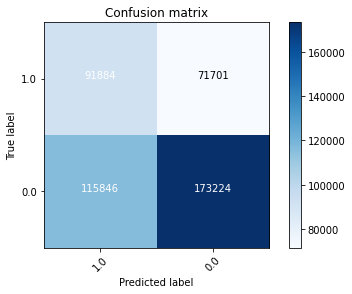

In [58]:
y_true = predictions_bsca.select("label")
y_true = y_true.toPandas()

y_pred = predictions_bsca.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [59]:

accuracy=(cnf_matrix[0][0]+cnf_matrix[1][1])/cnf_matrix.sum()
precision=(cnf_matrix[0][0])/(cnf_matrix[0][0]+cnf_matrix[1][0])
recall=(cnf_matrix[0][0])/(cnf_matrix[0][0]+cnf_matrix[0][1])
print("LR Model accuracy: ",accuracy)
print("LR Model precision: ",precision)
print("LR Model recall: ",recall)
print("LR Model F1-Score: ",(precision*recall)/(precision + recall))

LR Model accuracy:  0.5856734157360463
LR Model precision:  0.44232417079863284
LR Model recall:  0.561689641470795
LR Model F1-Score:  0.24745566432813113


In [60]:
accuracy = predictions_bsca.filter(predictions_bsca.label == predictions_bsca.prediction).count() / float(predictions_bsca.count())
print("Accuracy : ",accuracy)

Accuracy :  0.5856734157360463


In [61]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions_bsca))

Test Area Under ROC 0.5992446759090124


In [62]:
predictions_bsca.count()

452655

## FLBL Score

In [63]:
flbl_df = spark.read.parquet("s3a://as-bucket/client_data/flbl/ads_w_risk/data.parquet/*.parquet")
flbl_df.count()

369279

In [64]:
flbl_df.limit(5).toPandas()

,r_bill_fein,hdr_pay_to_prov_npi_id,li_proc_cd,hdr_diag_prim_cd,hdr_clm_tcn,batch_id,line_num,claim_srvc_days,diff_batch_srvc_dt,mod_59_ohe,...,proc_mod_MANUAL_THERAPY_1/>_REGIONS__DISTINCT_PROCEDURAL_SERVICE,proc_mod_MEASURE_BLOOD_OXYGEN_LEVEL__DISTINCT_PROCEDURAL_SERVICE,proc_mod_OFFICE_O/P_EST_SF_10-19_MIN__SIGNIFICANT_SEPARATELY_IDENTIFIABLE_EVAL_&_MGMT_SVC_SAME_PHYSCN_AND_DAY,proc_mod_PER_PM_REEVAL_EST_PAT_INFANT__SIGNIFICANT_SEPARATELY_IDENTIFIABLE_EVAL_&_MGMT_SVC_SAME_PHYSCN_AND_DAY,proc_mod_THER/PROPH/DIAG_INJ_IV_PUSH__DISTINCT_PROCEDURAL_SERVICE,proc_mod_UNKNOWN_PROCEDURE__NEW_EQUIPMENT,Target,diag_risk,proc_risk,prov_risk
0,590714812,None,93005,M1711,E100000897827210,20210623010,32.0,21,36,0,...,0,0,0,0,0,0,0,0.430526,0.356951,0.198873
1,219844877,None,25605,S52521A,E300000897766526,20210622010,1.0,0,105,0,...,0,0,0,0,0,0,1,0.465639,0.215520,0.343892
2,270730954,None,87481,N390,E300000905324033,20210730010,2.0,0,18,1,...,0,0,0,0,0,0,0,0.507492,0.804155,0.153976
3,596000308,None,A0425,R42,E300000914339145,20210903010,2.0,0,149,0,...,0,0,0,0,0,0,1,0.492483,0.618701,0.343892
4,123456789,None,99213,D235,E300000923431986,20211019010,2.0,0,141,0,...,0,0,0,0,0,0,1,0.392155,0.469090,0.343892


In [65]:
flbl_df.printSchema()

root
 |-- r_bill_fein: string (nullable = true)
 |-- hdr_pay_to_prov_npi_id: string (nullable = true)
 |-- li_proc_cd: string (nullable = true)
 |-- hdr_diag_prim_cd: string (nullable = true)
 |-- hdr_clm_tcn: string (nullable = true)
 |-- batch_id: string (nullable = true)
 |-- line_num: double (nullable = true)
 |-- claim_srvc_days: integer (nullable = true)
 |-- diff_batch_srvc_dt: integer (nullable = true)
 |-- mod_59_ohe: integer (nullable = true)
 |-- billed_amt_per_unit: double (nullable = true)
 |-- upcoded: integer (nullable = true)
 |-- unbundled_0: integer (nullable = true)
 |-- unbundled_1: integer (nullable = true)
 |-- plc_11: integer (nullable = true)
 |-- plc_12: integer (nullable = true)
 |-- plc_21: integer (nullable = true)
 |-- plc_22: integer (nullable = true)
 |-- plc_23: integer (nullable = true)
 |-- plc_24: integer (nullable = true)
 |-- plc_49: integer (nullable = true)
 |-- plc_81: integer (nullable = true)
 |-- prov_spec_Certified_Acupuncturist: integer (nul

In [66]:

features = [
'Target',
'claim_srvc_days',
'diff_batch_srvc_dt',
'mod_59_ohe',
'billed_amt_per_unit',
'upcoded',
'unbundled_0',
'unbundled_1',
'plc_11',
'plc_12',
'plc_21',
'plc_22',
'plc_23',
'plc_24',
'plc_49',
'plc_81',
'prov_spec_Chiropractor',
'prov_spec_Clinical_Psychology',
'prov_spec_Emergency_Medicine',
'prov_spec_Gastroenterology',
'prov_spec_Independent_Lab_Non-MD',
'prov_spec_Occupational_Therapist',
'prov_spec_Oncology',
'prov_spec_Pathology',
'prov_spec_Pediatrics',
'prov_spec_Special_Provider_Agreement',
'proc_mod_HPV_HIGH-RISK_TYPES__REFERENCE_OUTSIDE_LABORATORY',
'proc_mod_L_HRT_ARTERY/VENTRICLE_ANGIO__PROFESSIONAL_COMPONENT',
'proc_mod_MANUAL_THERAPY_1/>_REGIONS__DISTINCT_PROCEDURAL_SERVICE',
'proc_mod_MEASURE_BLOOD_OXYGEN_LEVEL__DISTINCT_PROCEDURAL_SERVICE',
'proc_mod_OFFICE_O/P_EST_SF_10-19_MIN__SIGNIFICANT_SEPARATELY_IDENTIFIABLE_EVAL_&_MGMT_SVC_SAME_PHYSCN_AND_DAY',
'proc_mod_PER_PM_REEVAL_EST_PAT_INFANT__SIGNIFICANT_SEPARATELY_IDENTIFIABLE_EVAL_&_MGMT_SVC_SAME_PHYSCN_AND_DAY',
'proc_mod_THER/PROPH/DIAG_INJ_IV_PUSH__DISTINCT_PROCEDURAL_SERVICE',
'proc_mod_UNKNOWN_PROCEDURE__NEW_EQUIPMENT',
'diag_risk',
'proc_risk',
'prov_risk']

In [67]:
flbl_data =  flbl_df.select(features)

In [68]:
cols = flbl_data.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(flbl_data)
flbl_data_2 = pipelineModel.transform(flbl_data)
selectedCols = ['label', 'vectorized_features','features'] + cols
flbl_data_2 = flbl_data_2.select(selectedCols)
flbl_data_2.printSchema()

root
 |-- label: double (nullable = false)
 |-- vectorized_features: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- Target: string (nullable = true)
 |-- claim_srvc_days: integer (nullable = true)
 |-- diff_batch_srvc_dt: integer (nullable = true)
 |-- mod_59_ohe: integer (nullable = true)
 |-- billed_amt_per_unit: double (nullable = true)
 |-- upcoded: integer (nullable = true)
 |-- unbundled_0: integer (nullable = true)
 |-- unbundled_1: integer (nullable = true)
 |-- plc_11: integer (nullable = true)
 |-- plc_12: integer (nullable = true)
 |-- plc_21: integer (nullable = true)
 |-- plc_22: integer (nullable = true)
 |-- plc_23: integer (nullable = true)
 |-- plc_24: integer (nullable = true)
 |-- plc_49: integer (nullable = true)
 |-- plc_81: integer (nullable = true)
 |-- prov_spec_Chiropractor: integer (nullable = true)
 |-- prov_spec_Clinical_Psychology: integer (nullable = true)
 |-- prov_spec_Emergency_Medicine: integer (nullable = true)
 |-- prov_spec_Ga

In [69]:
predictions_flbl = model.transform(flbl_data_2)

Confusion matrix, without normalization
[[ 64043  54970]
 [ 71329 178937]]


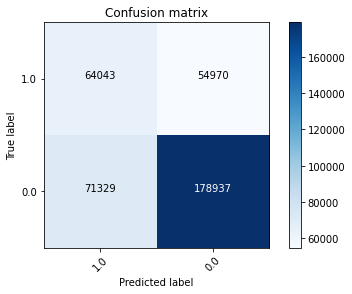

In [70]:
y_true = predictions_flbl.select("label")
y_true = y_true.toPandas()

y_pred = predictions_flbl.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [71]:

accuracy=(cnf_matrix[0][0]+cnf_matrix[1][1])/cnf_matrix.sum()
precision=(cnf_matrix[0][0])/(cnf_matrix[0][0]+cnf_matrix[1][0])
recall=(cnf_matrix[0][0])/(cnf_matrix[0][0]+cnf_matrix[0][1])
print("LR Model accuracy: ",accuracy)
print("LR Model precision: ",precision)
print("LR Model recall: ",recall)
print("LR Model F1-Score: ",(precision*recall)/(precision + recall))

LR Model accuracy:  0.6579848840578533
LR Model precision:  0.4730889696539905
LR Model recall:  0.5381176846226883
LR Model F1-Score:  0.25175619631660673


In [72]:
accuracy = predictions_flbl.filter(predictions_flbl.label == predictions_flbl.prediction).count() / float(predictions_flbl.count())
print("Accuracy : ",accuracy)


Accuracy :  0.6579848840578533


In [73]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions_flbl))

Test Area Under ROC 0.6687760842664559


In [74]:
predictions_flbl.count()

369279

In [76]:
model.summary

RuntimeError: No training summary available for this LogisticRegressionModel

In [108]:
w = list(model.coefficients)

In [109]:

feature_names = [
'claim_srvc_days',
'diff_batch_srvc_dt',
'mod_59_ohe',
'billed_amt_per_unit',
'upcoded',
'unbundled_0',
'unbundled_1',
'plc_11',
'plc_12',
'plc_21',
'plc_22',
'plc_23',
'plc_24',
'plc_49',
'plc_81',
'prov_spec_Chiropractor',
'prov_spec_Clinical_Psychology',
'prov_spec_Emergency_Medicine',
'prov_spec_Gastroenterology',
'prov_spec_Independent_Lab_Non-MD',
'prov_spec_Occupational_Therapist',
'prov_spec_Oncology',
'prov_spec_Pathology',
'prov_spec_Pediatrics',
'prov_spec_Special_Provider_Agreement',
'proc_mod_HPV_HIGH-RISK_TYPES__REFERENCE_OUTSIDE_LABORATORY',
'proc_mod_L_HRT_ARTERY/VENTRICLE_ANGIO__PROFESSIONAL_COMPONENT',
'proc_mod_MANUAL_THERAPY_1/>_REGIONS__DISTINCT_PROCEDURAL_SERVICE',
'proc_mod_MEASURE_BLOOD_OXYGEN_LEVEL__DISTINCT_PROCEDURAL_SERVICE',
'proc_mod_OFFICE_O/P_EST_SF_10-19_MIN__SIGNIFICANT_SEPARATELY_IDENTIFIABLE_EVAL_&_MGMT_SVC_SAME_PHYSCN_AND_DAY',
'proc_mod_PER_PM_REEVAL_EST_PAT_INFANT__SIGNIFICANT_SEPARATELY_IDENTIFIABLE_EVAL_&_MGMT_SVC_SAME_PHYSCN_AND_DAY',
'proc_mod_THER/PROPH/DIAG_INJ_IV_PUSH__DISTINCT_PROCEDURAL_SERVICE',
'proc_mod_UNKNOWN_PROCEDURE__NEW_EQUIPMENT',
'diag_risk',
'proc_risk',
'prov_risk']

In [110]:
len(w)

36

In [111]:
import math

In [117]:
feature_importance = pd.DataFrame(feature_names, columns = ["feature"])
feature_importance["importance"] = w
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
 


In [118]:
feature_importance

,feature,importance
34,proc_risk,0.726349
35,prov_risk,0.653009
33,diag_risk,0.059042
4,upcoded,0.046258
3,billed_amt_per_unit,0.038594
16,prov_spec_Clinical_Psychology,0.031534
6,unbundled_1,0.030429
9,plc_21,0.028976
10,plc_22,0.024215
5,unbundled_0,0.023044


In [130]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 15]

<Figure size 864x1440 with 0 Axes>

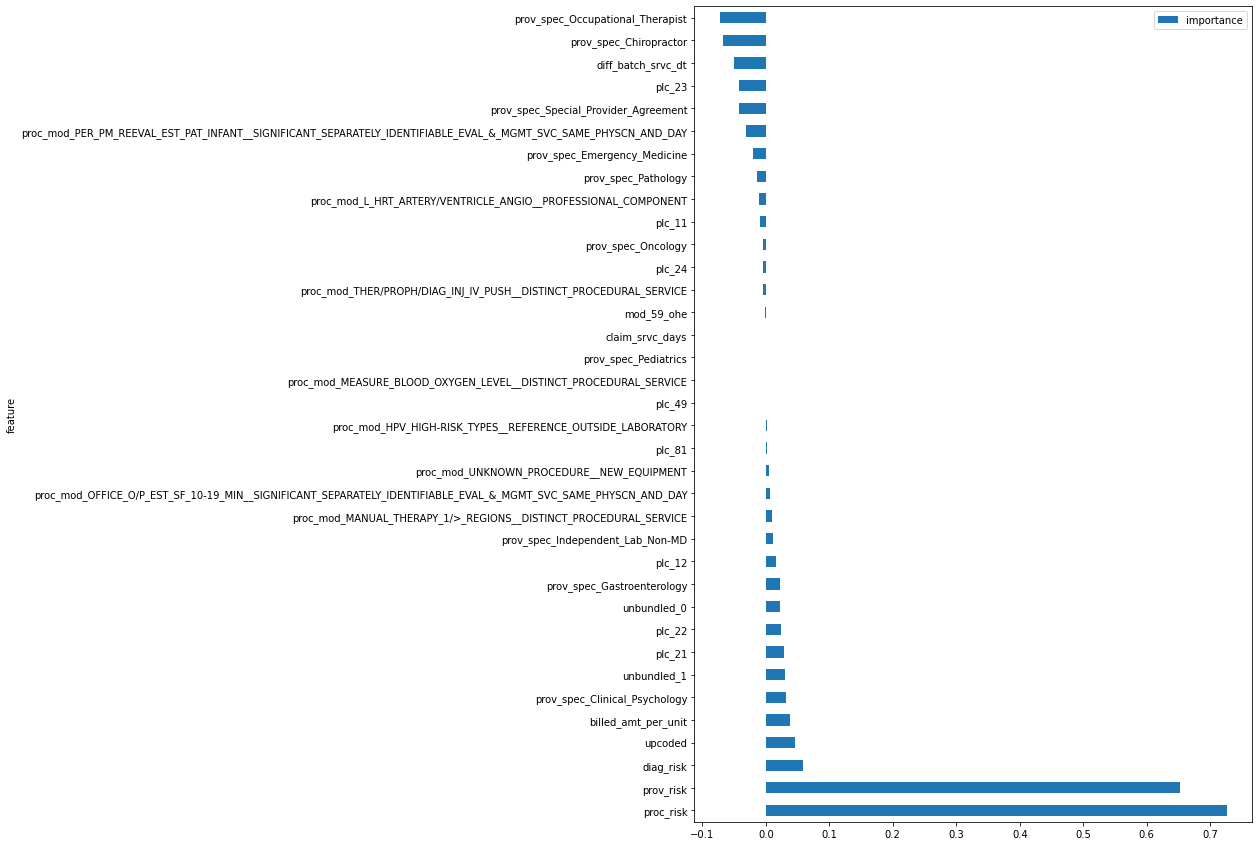

In [133]:
# from sklearn.linear_model import LogisticRegression
plt.figure(figsize=(12,20))
ax = feature_importance.plot.barh(x='feature', y='importance')
plt.show()
# plt.savefig('test.png', bbox_inches='tight')

In [120]:
plt.savefig('test.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>